In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

device:torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using PyTorch version:', torch.__version__, ' device:', device)

Using PyTorch version: 2.6.0+cu126  device: cuda


In [4]:
from torch.utils.data import Dataset
import pandas as pd
import os
from typing import Tuple

In [5]:
# 1
class MNISTDataset(Dataset):
    def __init__(self, path_csv: str):
        """
        Initializing the dataset, using a path towards the file where the dataset is located
        :param path_csv: path towards the file where the dataset is located
        """
        super().__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'The path {path_csv} does not indicate a file'
        self.path_csv = path_csv

        _all_digits : np.ndarray = pd.read_csv(path_csv, header=None).values
        _y : np.ndarray = _all_digits[:, 0]
        _x : np.ndarray = _all_digits[:, 1:]
        _x : np.ndarray = _x / 255
        self.x = _x
        self.y = _y

        self.x = torch.Tensor(self.x)
        self.y = torch.Tensor(self.y)

    def __len__(self):
        """
        Returns the length of the dataset
        :return: the length of the dataset
        """
        return len(self.y)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the pair entry-associated label situated on a certain position
        :param index: index on which the vector and its class is stored
        :return: pair: input vector with 784 elements and labels
        """
        return self.x[index, :], self.y[index]

In [6]:
train_ds : MNISTDataset = MNISTDataset('./data/mnist_train.csv')
test_ds : MNISTDataset = MNISTDataset('./data/mnist_test.csv')
assert len(train_ds) == 60000
assert len(test_ds) == 10000

In [7]:
from torch.utils.data import DataLoader
batch_size : int = 32 # depends on GPU
train_loader : DataLoader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader : DataLoader = DataLoader(test_ds, batch_size=batch_size)

# input data should be tensor with shape batch_size x 784
# labels should be tensor with shape of batch_size
for data, label in train_loader:
    print(data.shape, label.shape)
    break


torch.Size([32, 784]) torch.Size([32])


In [8]:
# 2
class MultiLogisticRegression(nn.Module):
    def __init__(self, input_size: int = 784, num_classes : int = 10):
        """
        Initializing an object of type MultiLogisticRegression
        :param input_size: size of input vector (in this case 784)
        :num_classes: number of classes (in this case 10 : 0-9)
        """
        super().__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.fully_connected = nn.Linear(input_size, num_classes, bias=True)

    # 4
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the multinomial logistic regression model
        :param x: input tensor of shape (batch_size, input_dim), where
                          input_dim is the number of features
        :return: output logits of shape (batch_size, num_classes)
        """
        x : torch.Tensor = self.fully_connected(x)
        # x = torch.softmax(x, dim=1) # manually logits -> probabilities; cross entropy loss does that internally regardless
        return x

In [9]:
model : MultiLogisticRegression = MultiLogisticRegression(input_size=784)

In [10]:
print(model)

MultiLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)


In [11]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MultiLogisticRegression                  --
├─Linear: 1-1                            7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

In [12]:
print(f'device={device}')
model.to(device)

device=cuda


MultiLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

In [13]:
for x, y in train_loader:

    x, y = x.to(device), y.to(device)

    y_hat : torch.Tensor = model(x).squeeze()

    # 3
    _, predicted_classes = torch.max(y_hat, dim=1) # [value, index]
    print(f'Probabilities: {predicted_classes}')

    print('How many classes were accurately predicted: ', (predicted_classes == y).sum())

    break

Probabilities: tensor([8, 2, 0, 2, 2, 8, 6, 5, 2, 1, 5, 6, 2, 5, 7, 5, 1, 5, 8, 7, 6, 8, 8, 1,
        5, 1, 1, 5, 8, 2, 7, 5], device='cuda:0')
How many classes were accurately predicted:  tensor(1, device='cuda:0')


In [14]:
loss_fn : torch.nn.modules.loss.CrossEntropyLoss = torch.nn.CrossEntropyLoss()

In [15]:

@torch.no_grad()
def test(model: nn.Module, loader: DataLoader, device: torch.device, loss_fn:nn.Module) -> Tuple[torch.Tensor, float] :
    """
    Tests the model on the data provided by :param loader:.
    :param model: binary logistic regression model
    :param loader: a dataloader that provides the data from the dataset being tested
    :param device: the device on which the model is running (CPU, GPU, TPU, etc.)
    :param loss_fn: loss function
    :return: prediction accuracy, prediction loss
    """

    correctly_classified: torch.Tensor = torch.tensor(0, dtype=torch.int, device=device)
    total_loss : float = 0
    total_items : int = 0

    model.eval()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        y_hat : torch.Tensor  = model(x).squeeze()

        _, predicted_classes = torch.max(y_hat, dim=1)

        correctly_classified += torch.sum(predicted_classes == y)
        total_loss : float = loss_fn(y_hat, y.long()).item() * len(x)
        total_items += len(x)

    mean_accuracy : torch.Tensor = correctly_classified / total_items
    mean_loss : float = total_loss / total_items

    return mean_accuracy, mean_loss

In [16]:
test_acc, test_loss = test(model, test_loader, device, loss_fn)
print(f'The accuracy of the untrained model: {test_acc * 100:.2f}%')
print(f'The error of the untrained model: {test_loss * 100:.5f}')

The accuracy of the untrained model: 6.27%
The error of the untrained model: 0.37306


In [17]:
optimizer : torch.optim.Optimizer  = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [18]:
epochs : int = 20

In [19]:
losses_train: list[float] = []
losses_test: list[float] = []
accuracies_train: list[float] = []
accuracies_test: list[float] = []
for epoch in range(epochs):
    model.train()
    epoch_loss : int = 0
    total_items : int = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # deleting the previously calculated gradients
        model.zero_grad()

        # predicting conditional probabilities for minibatch of given model
        y_hat : torch.Tensor = torch.squeeze(model(x))

        # calculating loss function for minibatch
        loss : torch.nn.modules.loss.CrossEntropyLoss = loss_fn(y_hat, y.long())

        # calculating gradients
        loss.backward()

        # optimizer applies gradients => learning
        optimizer.step()

    train_acc, train_loss = test(model, train_loader, device, loss_fn)
    test_acc, test_loss = test(model, test_loader, device, loss_fn)
    losses_train.append(train_loss)
    accuracies_train.append(train_acc)
    losses_test.append(test_loss)
    accuracies_test.append(test_acc)

    print(f'Epoch: {epoch + 1}/{epochs}: train loss = {train_loss:.7f}')
    print(f'Epoch: {epoch + 1}/{epochs}: test loss = {test_loss:.7f}')
    print(f'Epoch: {epoch + 1}/{epochs}: accuracy on train set = {train_acc * 100:.4f}%')
    print(f'Epoch: {epoch + 1}/{epochs}: accuracy on test set  = {test_acc * 100:.4f}%\n')

Epoch: 1/20: train loss = 0.0001512
Epoch: 1/20: test loss = 0.0002644
Epoch: 1/20: accuracy on train set = 91.3300%
Epoch: 1/20: accuracy on test set  = 91.6700%

Epoch: 2/20: train loss = 0.0001102
Epoch: 2/20: test loss = 0.0002048
Epoch: 2/20: accuracy on train set = 92.1300%
Epoch: 2/20: accuracy on test set  = 92.2000%

Epoch: 3/20: train loss = 0.0002895
Epoch: 3/20: test loss = 0.0002060
Epoch: 3/20: accuracy on train set = 92.4667%
Epoch: 3/20: accuracy on test set  = 92.4200%

Epoch: 4/20: train loss = 0.0000391
Epoch: 4/20: test loss = 0.0002229
Epoch: 4/20: accuracy on train set = 92.5700%
Epoch: 4/20: accuracy on test set  = 92.5900%

Epoch: 5/20: train loss = 0.0001394
Epoch: 5/20: test loss = 0.0002084
Epoch: 5/20: accuracy on train set = 92.7667%
Epoch: 5/20: accuracy on test set  = 92.6400%

Epoch: 6/20: train loss = 0.0000966
Epoch: 6/20: test loss = 0.0002063
Epoch: 6/20: accuracy on train set = 93.0433%
Epoch: 6/20: accuracy on test set  = 92.6200%

Epoch: 7/20: tra

In [20]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

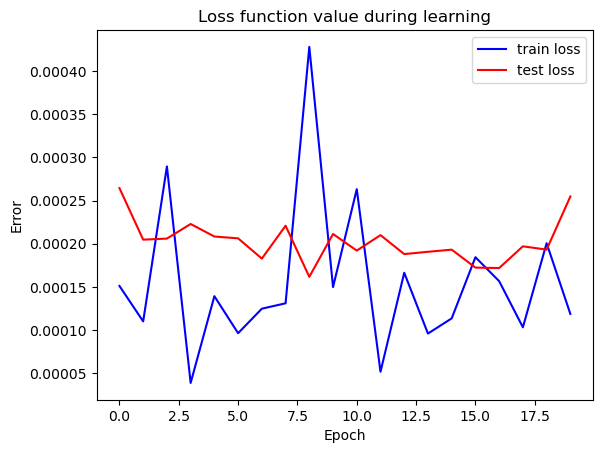

In [21]:
plt.plot(losses_train, label='train loss', color='blue')
plt.plot(losses_test, label='test loss', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title(f'Loss function value during learning')
plt.show()

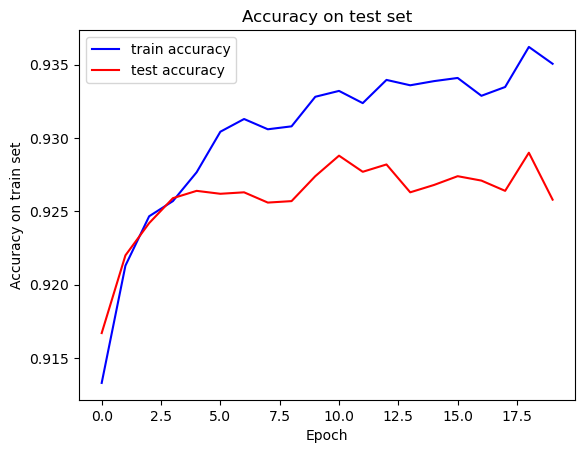

In [22]:
plt.plot([acc.cpu().item() for acc in accuracies_train], label='train accuracy', color='blue')
plt.plot([acc.cpu().item() for acc in accuracies_test], label='test accuracy', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy on train set')
plt.title(f'Accuracy on test set')
plt.show()